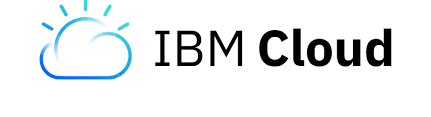

# Case Study - Data ingestion

The goal of this case study is to put into practice the important concepts from module 1.  We will go through the basic process that begins with refining the business opportunity and ensuring that it is articulated using a scientific thought process.

You will be gathering data from several provided sources, staging it for quality assurance and saving it in a target destination that is most appropriate.


## Case study overall objectives

1. Gather all relevant data from the sources of provided data
2. Implement several checks for quality assurance 
3. Take the initial steps towards automation of the ingestion pipeline

## Getting started

Download this notebook and open it locally using a Jupyter server. Alternatively you may use Watson Studio.  To make using Watson Studio easier we have provided a zip archive file containing the files needed to complete this case study in Watson Studio.

**You will need the following files to complete this case study**

* m1-u6-case-study.ipynb
* m1-u6-case-study-solution.ipynb
* aavail-customers.db
* aavail-steams.csv

1. Fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***
2. When you have finished the case study there will be a short quiz

You may review the rest of this content as part of the notebook, but once you are ready to get started be ensure that you are working with a *live* version either as part of Watson Studio or locally.

## Data Sources

The data you will be sourcing from is contained in two sources.

1. A database ([SQLite](https://www.sqlite.org/index.html)) of `customer` data
2. A [CSV file](https://en.wikipedia.org/wiki/Comma-separated_values) of `stream` level data

   >You will create a simple data pipeline that
   (1) simplifies the data for future analysis
   (2) performs quality assurance checks.

The process of building *the data ingestion pipeline* entails extracting data, transforming it, and loading it into an appropriate data storage technology.  When constructing a pipeline it is important to keep in mind that they generally process data in batches.  For example, data may be compiled during the day and the batch could be processed during the night.  The data pipeline may also be optimized to execute as a streaming computation (i.e., every event is handled as it occurs).

## PART 1: Gathering the data

The following is an [Entity Relationship Diagram (ERD)](https://en.wikipedia.org/wiki/Entity%E2%80%93relationship_model) that details the tables and contents of the database.



In [7]:
## all the imports you will need for this case study
import os
from datetime import datetime
import scipy.stats as stats
import pandas as pd
import numpy as np
import sqlite3

## specify the directory you saved the data in
data_dir = os.path.join("..","data")

Much of the data exist in a database.  You can connect to is using the `sqlite3` Python package with the function shown below.  Note that is is good practice to wrap your connect functions in a [try-except statement](https://docs.python.org/3/tutorial/errors.html) to cleanly handle exceptions.

In [8]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except Error as e:
        print("...unsuccessful connection\n",e)
    
    return(conn)

In [9]:
## make the connection to the database
conn = connect_db(os.path.join(data_dir,"aavail-customers.db"))

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


### QUESTION 1:

**extract the relevant data from the DB**

Query the database and extract the following data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
 
* Customer ID (integer)
* Last name
* First name
* DOB
* City
* State
* Country (the name NOT the country_id)
* Gender

Remember that that SQL is case-insensitive, but it is traditional to use ALL CAPS for SQL keywords. It is also a convention to end SQL statements with a semi-colon.  

#### Resources

* [W3 schools SQL tutorial](https://www.w3schools.com/sql)
* [W3 schools SQL joins](https://www.w3schools.com/sql/sql_join.asp)

In [15]:
## YOUR CODE HERE
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

_data = [d for d in conn.execute(query)]
columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender"]
df_db = pd.DataFrame(_data,columns=columns)
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m


### QUESTION 2:

**Extract the relevant data from the CSV file**

For each ```customer_id``` determine if a customer has stopped their subscription or not and save it in a dictionary or another data container.

In [11]:
df_streams = pd.read_csv(os.path.join(data_dir,r"aavail-streams.csv"))
df_streams.head()

,customer_id,stream_id,date,invoice_item_id,subscription_stopped
0,1,1420.0,2018-10-21,2.0,0
1,1,1343.0,2018-10-23,2.0,0
2,1,1756.0,2018-11-05,2.0,0
3,1,1250.0,2018-11-06,2.0,0
4,1,1324.0,2018-11-12,2.0,0


In [12]:
## YOUR CODE HERE
customer_ids = df_streams['customer_id'].values
unique_ids = np.unique(df_streams['customer_id'].values)
streams = df_streams['subscription_stopped'].values
has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})
df_churn.head()

,customer_id,is_subscriber
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


## PART 2: Checks for quality assurance

Sometimes it is known in advance which types of data integrity issues to expect, but other times it is during the Exploratory Data Analysis (EDA) process that these issues are identified.  After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Here you will combine the data into a single structure and provide a couple checks for quality assurance.

### QUESTION 3: 

**Implement checks for quality assurance**

1. Remove any repeat customers based on ```customer_id```
2. Remove stream data that do not have an associated ```stream_id```
3. Check for missing values

In [13]:
## YOUR CODE HERE

print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = df_db.duplicated()
if True in duplicate_rows:
    df_db = df_db[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

missing_stream_ids = np.isnan(df_streams['stream_id'])    
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 7 duplicate rows
Removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id      0
last_name        0
first_name       0
DOB              0
city             0
state          300
country          0
gender           0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


### QUESTION 4: 

**combine the data into a single data structure**

For this example, the two most convenient structures for this task are Pandas dataframes and NumPy arrays.  At a minimum ensure that your structure accommodates the following.

1. A column for `customer_id`
2. A column for `country`
3. A column for ```age``` that is created from ```DOB```
4. A column ```customer_name``` that is created from ```first_name``` and ```last_name```
5. A column to indicate churn called ```is_subscriber```
7. A column that indicates ```subscriber_type``` that comes from ```invoice_item```
6. A column to indicate the total ```num_streams```

> HINT: For the subscriber type use the most frequent invoice_item

#### Resources

* [Python's datetime library](https://docs.python.org/3/library/datetime.html)
* [NumPy's datetime data type](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html)


In [66]:
## YOUR CODE HERE

df_clean = df_churn.copy()
df_clean = df_clean[np.in1d(df_clean['customer_id'].values,df_db['customer_id'].values)]
unique_ids = df_clean['customer_id'].values

## ensure we are working with correctly ordered customer_ids df_db
if not np.array_equal(df_clean['customer_id'],df_db['customer_id']): 
    raise Exception("indexes are out of order or unmatched---needs to fix")

## query the db t create a invoice item map
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""

## variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
streams_stopped = df_streams['subscription_stopped'].values
streams_cid = df_streams['customer_id'].values
streams_iid = df_streams['invoice_item_id'].values
subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

## create the new df
df_clean['country'] = df_db['country']
df_clean['age'] = np.datetime64('today') - df_db['DOB'].astype('datetime64')
df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]

## convert age to days
df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]

df_clean.head()

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,21,Kasen Todd,aavail_premium,23
1,2,0,singapore,30,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,21,Lillian Carey,aavail_premium,22
3,4,1,united_states,20,Beau Christensen,aavail_basic,19
4,5,1,singapore,21,Ernesto Gibson,aavail_premium,23


## PART 3: Automating the process

To ensure that you code can be used to automate this process.  First you will save you dataframe or numpy array as a CSV file.  

### QUESTION 5:

**Take the initial steps towards automation**

1. Save your cleaned, combined data as a CSV file.
2. From the code above create a function or class that performs all of the steps given a database file and a streams CSV file.
3. Run the function in batches and write a check to ensure you got the same result that you did in the code above.

There will be some logic involved to ensure that you do not write the same data twice to the target CSV file.

Shown below is some code that will split your streams file into two batches. 

In [22]:
## code to split the streams csv into batches
df_all = pd.read_csv(os.path.join(data_dir,"aavail-streams.csv"))
half = int(round(df_all.shape[0] * 0.5))
df_part1 = df_all[:half]
df_part2 = df_all[half:]
df_part1.to_csv(os.path.join(data_dir,"aavail-streams-1.csv"),index=False)
df_part2.to_csv(os.path.join(data_dir,"aavail-streams-2.csv"),index=False)

You will need to save your function as a file.  The following cell demonstrates how to do this from within a notebook. 

In [1]:
%%writefile aavail-data-ingestor.py
#!/usr/bin/env python

import os
import sys
import getopt
import scipy.stats as stats
import pandas as pd
import numpy as np
import sqlite3

DATA_DIR = os.path.join("..","data")

def connect_db(file_path):
    """
    function to connection to aavail database
    """
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db")
    except Error as e:
        print("...unsuccessful connection",e)
    
    return(conn)

def ingest_db_data(conn):
    """
    load and clean the db data
    """
    
    query = """
            SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
            cu.city, cu.state, co.country_name, cu.gender
            FROM CUSTOMER cu
            INNER JOIN COUNTRY co
            ON cu.country_id = co.country_id;
            """
    _data = [d for d in conn.execute(query)]
    columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender"]
    df_db = pd.DataFrame(_data,columns=columns)
    duplicate_rows = df_db.duplicated()
    if True in duplicate_rows:
        df_db = df_db[~duplicate_rows]
        df_db.reset_index()
    print("... removed {} duplicate rows in db data".format(np.where(duplicate_rows==True)[0].size))
    return(df_db)

def ingest_stream_data(file_path):
    """
    load and clean the stream data
    """
    
    df_streams = pd.read_csv(file_path)
    customer_ids = df_streams['customer_id'].values
    unique_ids = np.unique(df_streams['customer_id'].values)
    streams = df_streams['subscription_stopped'].values
    has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
    df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})
    
    missing_stream_ids = np.isnan(df_streams['stream_id'])    
    if True in missing_stream_ids:
        df_streams = df_streams[~missing_stream_ids]
        df_streams.reset_index()
    print("... removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))
    
    return(df_streams,df_churn)

def process_dataframes(df_db,df_streams,df_churn,conn):
    """
    add data to target csv
    """

    df_clean = df_churn.copy()
    df_db = df_db[np.in1d(df_db['customer_id'].values,df_clean['customer_id'].values)]
    df_db.reset_index()
    unique_ids = df_clean['customer_id'].values

    ## ensure we are working with correctly ordered customer_ids df_db
    if not np.array_equal(df_clean['customer_id'],df_db['customer_id']):
        raise Exception("indexes are out of order or unmatched---needs to fix")

    ## query the db t create a invoice item map
    query = """
    SELECT i.invoice_item_id, i.invoice_item
    FROM INVOICE_ITEM i;
    """

    ## variables for new df creation
    invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
    streams_stopped = df_streams['subscription_stopped'].values
    streams_cid = df_streams['customer_id'].values
    streams_iid = df_streams['invoice_item_id'].values
    subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

    ## create the new df
    df_clean['country'] = df_db['country']
    df_clean['age'] = np.datetime64('today') - df_db['DOB'].astype('datetime64')
    df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]
    df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
    df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
    df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]
    
    return(df_clean)
    
def update_target(target_file,df_clean,overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df_clean.to_csv(target_file,index=False)   
    else:
        df_target = pd.read_csv(target_file)
        df_target.to_csv(target_file, mode='a',index=False)
         
if __name__ == "__main__":
  
    ## collect args
    arg_string = "%s -d db_filepath -s streams_filepath"%sys.argv[0]
    try:
        optlist, args = getopt.getopt(sys.argv[1:],'d:s:')
    except getopt.GetoptError:
        print(getopt.GetoptError)
        raise Exception(arg_string)

    ## handle args
    streams_file = None
    db_file = None
    for o, a in optlist:
        if o == '-d':
            db_file = a
        if o == '-s':
            streams_file = a
    streams_file = os.path.join(DATA_DIR,streams_file)
    db_file = os.path.join(DATA_DIR,db_file)
    target_file = os.path.join(DATA_DIR,"aavail-target.csv")
    
    ## make the connection to the database
    conn = connect_db(db_file)

    ## ingest data base data
    df_db = ingest_db_data(conn)
    df_streams, df_churn = ingest_stream_data(streams_file)
    df_clean = process_dataframes(df_db, df_streams, df_churn, conn)
    
    ## write
    update_target(target_file,df_clean,overwrite=False)
    print("done")

Writing aavail-data-ingestor.py


You will also need to be able to pass the file names to your function without hardcoding them into the script itself.  This is an important step towards automation.  Here are the two libraries commonly used to accomplish this in Python.

* [getopt](https://docs.python.org/3/library/getopt.html)
* [argparse](https://docs.python.org/3/library/argparse.html)

You may run the script you just created from the commandline directly or from within this notebook using:

In [19]:
!python aavail-data-ingestor.py aavail-customers.db aavail-streams-1.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 1164 missing stream ids
   customer_id  is_subscriber  ...   subscriber_type  num_streams
0            1              1  ...    aavail_premium           23
1            2              0  ...  aavail_unlimited           12
2            3              0  ...    aavail_premium           22
3            4              1  ...      aavail_basic           19
4            5              1  ...    aavail_premium           23

[5 rows x 7 columns]


Run the script once for each batch that you created and then load both the original and batch versions back into the notebook to check that they are the same. 

In [86]:
## YOUR CODE HERE

!rm ../data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams.csv
!wc -l ../data/aavail-target.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 1164 missing stream ids
done
    1001 ../data/aavail-target.csv


In [87]:
!rm ../data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-1.csv
!wc -l ../data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-2.csv
!wc -l ../data/aavail-target.csv

...successfully connected to db
... removed 7 duplicate rows in db data
... removed 577 missing stream ids
done
     507 ../data/aavail-target.csv
...successfully connected to db
... removed 7 duplicate rows in db data
... removed 587 missing stream ids
done
    1014 ../data/aavail-target.csv


### QUESTION 6:

**How can you improve the process?**

In paragraph form or using bullets write down some of the ways that you could improve this pipeline.

YOUR ANSWER HERE


